## Imports

In [1]:
import sys
import math
import warnings

import psycopg2
import wrds
import gzip

import seaborn as sns
import os
import quandl
import json
import zipfile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import functools
import requests
import io

import urllib.request
from urllib.error import HTTPError
# from html_table_parser.parser import HTMLTableParser
from bs4 import BeautifulSoup
import re

import plotnine as p9
from plotnine import ggplot, scale_x_date, guides, guide_legend, geom_bar, scale_y_continuous, \
    scale_color_identity, geom_line, geom_point, labs, theme_minimal, theme, element_blank, element_text, \
        geom_ribbon, geom_hline, aes, scale_size_manual, scale_color_manual, ggtitle

from datetime import datetime
import datetime

import pandas as pd
# import pandas_market_calendars as mcal
from pandas.plotting import autocorrelation_plot
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import scipy as sp
from scipy.stats import norm
import scipy.stats as stats

from statsmodels.tsa.stattools import coint
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

from collections import deque
from bisect import insort, bisect_left
from itertools import islice


c:\Users\jrecc\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\jrecc\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
tbills = pd.read_csv('tbill_data.csv')
tbills = tbills.rename(columns = {
    'TMATDT': 'maturity_date',
    'CALDT': 'quote_date',
    'TDNOMPRC': 'price',
    'TDDURATN': 'dte'
})

tbills = tbills.iloc[:, [2, 6, 9, 10]]
tbills['maturity_date'] = pd.to_datetime(tbills['maturity_date'])
tbills['quote_date'] = pd.to_datetime(tbills['quote_date'])

In [3]:
calls = pd.read_csv('calls.csv')
calls['date_x'] = pd.to_datetime(calls['date_x'])
calls['exdate'] = pd.to_datetime(calls['exdate'])
calls.loc[:, 'dte'] = (calls.loc[:, 'exdate'] - calls.loc[:, 'date_x']).dt.days
puts = pd.read_csv('puts.csv')
puts['date_x'] = pd.to_datetime(puts['date_x'])
puts['exdate'] = pd.to_datetime(puts['exdate'])
puts.loc[:, 'dte'] = (puts.loc[:, 'exdate'] - puts.loc[:, 'date_x']).dt.days


In [4]:
option_data = pd.read_csv('option_data.csv')

In [5]:
option_data['midpt'] = (option_data['best_bid'] + option_data['best_offer'])/2
option_data['date'] = pd.to_datetime(option_data['date'])
option_data['exdate'] = pd.to_datetime(option_data['exdate'])
option_data.loc[:, 'dte'] = (option_data.loc[:, 'exdate'] - option_data.loc[:, 'date']).dt.days
option_data

,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,expiry_indicator,midpt,dte
0,2018-01-02,2018-01-03,2017-12-28,C,235000.0,33.59,33.81,0.0,187.0,NaN,NaN,NaN,NaN,NaN,w,33.700,1
1,2018-01-02,2018-01-03,2018-01-02,C,240000.0,28.59,28.76,1.0,88.0,NaN,NaN,NaN,NaN,NaN,w,28.675,1
2,2018-01-02,2018-01-03,2017-12-27,C,242500.0,26.09,26.32,0.0,2.0,NaN,NaN,NaN,NaN,NaN,w,26.205,1
3,2018-01-02,2018-01-03,2018-01-02,C,245000.0,23.59,23.81,12.0,58.0,NaN,NaN,NaN,NaN,NaN,w,23.700,1
4,2018-01-02,2018-01-03,NaN,C,247500.0,21.08,21.32,0.0,0.0,NaN,NaN,NaN,NaN,NaN,w,21.200,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10448189,2023-02-28,2025-03-21,2022-12-28,P,600000.0,200.50,205.50,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,203.000,752
10448190,2023-02-28,2025-03-21,NaN,P,605000.0,205.50,210.50,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,208.000,752
10448191,2023-02-28,2025-03-21,NaN,P,610000.0,210.00,215.00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,212.500,752
10448192,2023-02-28,2025-03-21,NaN,P,615000.0,215.00,220.00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,217.500,752


In [6]:
spydata = pd.read_csv('spy_tickerdata.csv')
spydata['date'] = pd.to_datetime(spydata['date'])

In [7]:
def find_closest_index(val, col2):
    return np.abs(col2 - val).idxmin()

In [77]:
def calculate_iv_calls(df, delta_k, s_0, zcb_price):
    options_df = df.copy()
    options_df['adjusted_strike'] = options_df['strike_price'] / (zcb_price/100)

    options_df['closest_price_index'] = options_df['adjusted_strike'].apply(lambda x: find_closest_index(x, options_df['strike_price']))

    options_prices = options_df.loc[options_df['closest_price_index'].values, 'midpt']

    underlying_minus_strike = s_0 - (options_df['strike_price']/1000)
    underlying_minus_strike[underlying_minus_strike < 0] = 0
    options_prices.index = underlying_minus_strike.index
    options_df['g'] = (options_prices - underlying_minus_strike)/((options_df['strike_price']/1000)**2)
    
    options_df.iloc[1:-2, -1] = options_df.iloc[1:-2, -1] * 2
    return options_df.iloc[:, -1].sum() * delta_k

In [83]:
def calculate_iv_no_adjustment(df, delta_k, s_0, zcb_price):
    options_df = df.copy()
    # options_df['adjusted_strike'] = options_df['strike_price'] / (zcb_price/100)

    # options_df['closest_price_index'] = options_df['adjusted_strike'].apply(lambda x: find_closest_index(x, options_df['strike_price']))

    options_prices = options_df.loc[:, 'midpt']

    underlying_minus_strike = s_0 - (options_df['strike_price']/1000)
    underlying_minus_strike[underlying_minus_strike < 0] = 0
    # options_prices.index = underlying_minus_strike.index
    options_df['g'] = (options_prices - underlying_minus_strike)/((options_df['strike_price']/1000)**2)
    
    options_df.iloc[1:-2, -1] = options_df.iloc[1:-2, -1] * 2
    return options_df.iloc[:, -1].sum() * delta_k

In [85]:
# Calculate IV by removing tail strike values
our_ivs = pd.DataFrame(columns = ['iv'])
our_ivs_no_adj = pd.DataFrame(columns = ['iv'])
sizes = pd.Series()

for ind, dt in enumerate(calls['date_x']):
    call_df = option_data[(option_data['date'] == dt) & (option_data['cp_flag'] == 'C')]
    call_df = call_df[call_df['dte'] == calls.loc[ind, 'dte']]
    call_df = call_df.sort_values('strike_price')

    call_df = call_df.reset_index(drop = True)

    call_df['increments'] = call_df['strike_price'].diff().fillna(0)

    mode = call_df['increments'].mode().iloc[0]
    inds_to_drop = pd.Series(call_df[call_df['increments'] > mode].index)
    midpoint = call_df.shape[0]/2
    inds_to_drop
    lower_inds_to_drop = inds_to_drop[inds_to_drop < midpoint]
    upper_inds_to_drop = inds_to_drop[inds_to_drop > midpoint]

    if not lower_inds_to_drop.empty:
        call_df = call_df.iloc[lower_inds_to_drop.max():]

    if not upper_inds_to_drop.empty:
        call_df = call_df.iloc[:upper_inds_to_drop.min()]

    valid_strikes = np.arange(start = int(call_df['strike_price'].min()), stop = call_df['strike_price'].max() + mode, step = mode)
    call_df = call_df[call_df['strike_price'].isin(valid_strikes)]
    
    # look at how many options are being used to find IV
    sizes.loc[ind] = call_df.shape[0]
    
    delta_k = mode/1000

    s_0 = spydata[spydata['date'] == dt]['close'].iloc[0]
    dte = call_df['dte'].iloc[0]

    tbills_today = tbills[(tbills['quote_date'] == dt)]
    days_back = -1
    while tbills_today.empty:
        tbills_today = tbills[tbills['quote_date'] == dt + pd.Timedelta(days = days_back)]
        days_back -= 1
    zcb_price = tbills_today[abs(tbills_today['dte'] - dte) == abs(tbills_today['dte'] - dte).min()]['price'].iloc[0]

    iv = calculate_iv_calls(call_df, delta_k, s_0, zcb_price)
    iv_no_adj = calculate_iv_no_adjustment(call_df, delta_k, s_0, zcb_price)
    
    our_ivs.loc[dt] = [iv]
    our_ivs_no_adj[dt] = [iv_no_adj]

C:\Users\jrecc\AppData\Local\Temp\ipykernel_18592\2731181974.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\jrecc\AppData\Local\Temp\ipykernel_18592\2731181974.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\jrecc\AppData\Local\Temp\ipykernel_18592\2731181974.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fr

In [86]:
our_ivs = our_ivs.reset_index().rename(columns = {'index':'date'})
our_ivs_no_adj = our_ivs_no_adj.reset_index().rename(columns = {'index':'date'})

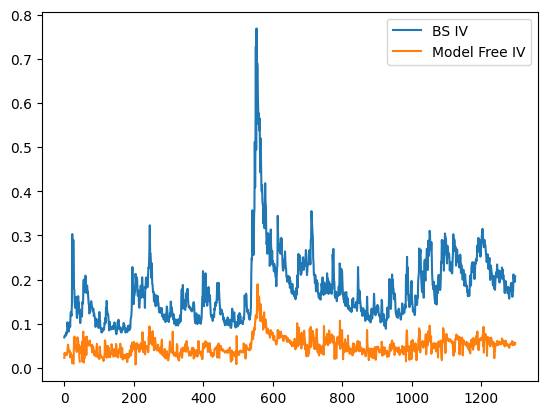

In [102]:
plt.plot(calls['impl_volatility_x'])
plt.plot(our_ivs['iv']**(0.5))
plt.legend(['BS IV', 'Model Free IV'])

In [93]:
our_ivs_no_adj = our_ivs_no_adj.T.iloc[2:]
our_ivs_no_adj = our_ivs_no_adj.reset_index().rename(columns = {'index':'date', 0:'iv'})

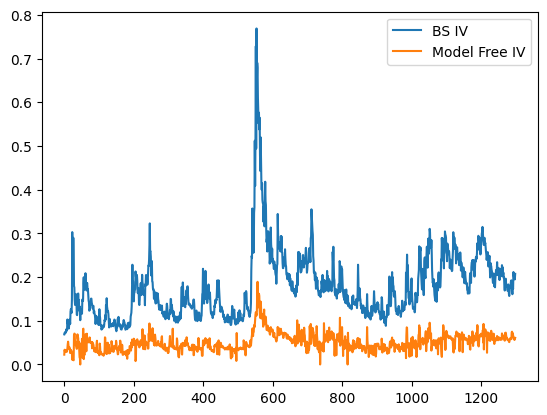

In [114]:
plt.plot(calls['impl_volatility_x'])
plt.plot((our_ivs_no_adj['iv'])**0.5)
plt.legend(['BS IV', 'Model Free IV'])

In [100]:
# Calculate IV by using all values and interpolating

our_ivs_interp = pd.DataFrame(columns = ['iv'])
sizes_interp = pd.Series()

for ind, dt in enumerate(calls['date_x']):
    call_df = option_data[(option_data['date'] == dt) & (option_data['cp_flag'] == 'C')]
    call_df = call_df[call_df['dte'] == calls.loc[ind, 'dte']]
    call_df = call_df.sort_values('strike_price')

    call_df = call_df.reset_index(drop = True)

    call_df['increments'] = call_df['strike_price'].diff().bfill()
    delta_k = call_df['increments'].min()

    interp_strikes = pd.Series(np.arange(start=call_df['strike_price'].min(), step = delta_k, stop = call_df['strike_price'].max() + delta_k))
    
    strikes_to_calc = interp_strikes[~interp_strikes.isin(call_df['strike_price'])].reset_index(drop= True)
    interp_prices = pd.Series(np.interp(interp_strikes[~interp_strikes.isin(call_df['strike_price'])], call_df['strike_price'], call_df['midpt']))

    interp_df = pd.DataFrame(data = {'strike_price': strikes_to_calc, 'midpt':interp_prices})
    df_for_calc = pd.concat([call_df[['strike_price', 'midpt']], interp_df]).sort_values('strike_price').reset_index(drop = True)
    
    # look at how many options are being used to find IV
    sizes_interp.loc[ind] = df_for_calc.shape[0]
    
    delta_k = delta_k/1000

    s_0 = spydata[spydata['date'] == dt]['close'].iloc[0]
    dte = call_df['dte'].iloc[0]

    tbills_today = tbills[(tbills['quote_date'] == dt)]
    days_back = -1
    while tbills_today.empty:
        tbills_today = tbills[tbills['quote_date'] == dt + pd.Timedelta(days = days_back)]
        days_back -= 1
    zcb_price = tbills_today[abs(tbills_today['dte'] - dte) == abs(tbills_today['dte'] - dte).min()]['price'].iloc[0]

    
    iv = calculate_iv_calls(df_for_calc, delta_k, s_0, zcb_price)
    
    our_ivs_interp.loc[dt] = [iv]

In [115]:
our_ivs_interp = our_ivs_interp.reset_index().rename(columns = {'index':'date'})

our greater: 9 
Ours Less: 1244


In [122]:
diffs = (our_ivs_interp['iv'])**(0.5) - calls['impl_volatility_x']
print(f'our greater: {diffs[diffs > 0].count()} \nOurs Less: {diffs[diffs < 0].count()}')

our greater: 9 
Ours Less: 1244


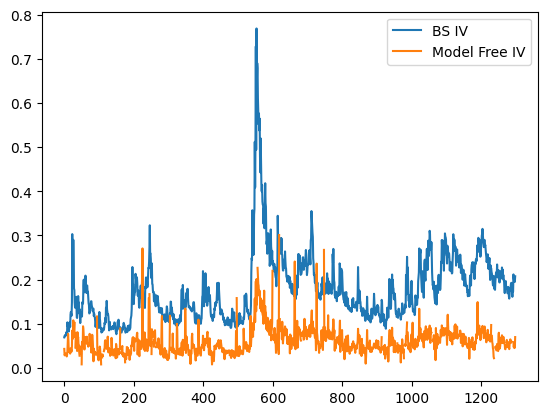

In [104]:
plt.plot(calls['impl_volatility_x'])
plt.plot(our_ivs_interp['iv']**(0.5))
plt.legend(['BS IV', 'Model Free IV'])